In [1]:
import iris
import iris.cube
import os
import cmocean
import matplotlib.pyplot as plt

In [2]:
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from plotting_functions import bias_plots as bias_plots2

In [34]:
path="/g/data/tp28/BARPA/trials/{domain}/era/erai/historical/r0/pp_unified/mon/{var}/{grid}/{year:04d}/{var}_{domain}_erai_historical_r0_BARPA*_mon_{year:04d}{month:02d}*.nc" 
cx = iris.Constraint(longitude=lambda x: 140<=x<=155)
cy = iris.Constraint(latitude =lambda y: -10.5>=y>=-44)
lsm = iris.load_cube("/home/548/eh6215/lsm.nc","land_binary_mask").extract(cx&cy)

yearmons = [[(year,12),(year,1),(year,2)] for year in range(1991,2015)]
yearmons = [item for sublist in yearmons for item in sublist]


In [4]:
def load_barpa_esci(year,month,domain,var,Constraints,std_grid=False):
  if std_grid:
    data = iris.load_cube(path.format(year=year,month=month,domain=domain,var=var,grid='0.05deg'))
  else:
    grid = {"BARPA-EASTAUS_12km":"0p11deg","BARPAC-T_km4p4":"0p04deg","BARPAC-M_km2p2":"0p02deg"}[domain]
    data = iris.load_cube(path.format(year=year,month=month,domain=domain,var=var,grid=grid),Constraints)
  return data

In [6]:
def regrid(data,template):
  for cube in [data,template]:
     for coord in ['longitude','latitude']:
        cube.coord(coord).coord_system = None
        try:
          cube.coord(coord).guess_bounds()
        except ValueError:
          1
  return data.regrid(template,iris.analysis.AreaWeighted())

In [7]:


def load_agcd(year,month,Constraints):
    ct = iris.Constraint(time=lambda t: t.point.month==month)
    data = iris.load_cube("/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_%d.nc"%year,Constraints&ct)
    return data

In [35]:
data = {}
names = {'barpaR-E': "BARPA-EASTAUS_12km", 'barpaC-T':"BARPAC-T_km4p4","barpaC-M":"BARPAC-M_km2p2"}
for name in names:
    data[name] = {}
    data[name]['pr'] = iris.cube.CubeList([load_barpa_esci(year,mon,names[name], "pr",cx&cy) for (year,mon) in yearmons])
    iris.util.equalise_attributes(data[name]['pr'])
    data[name]['pr'] = data[name]['pr'].concatenate_cube()
    data[name]['pr'] = regrid(data[name]['pr'],lsm)
    
  

In [36]:
data['agcd'] = {}
data['agcd']['pr'] = iris.cube.CubeList([load_agcd(year,mon,cx&cy) for (year,mon) in yearmons])
iris.util.equalise_attributes(data['agcd']['pr'])
data['agcd']['pr']= regrid(data['agcd']['pr'].merge_cube(),lsm)
data['agcd']['pr'].units = 'mm/month'
data['agcd']['pr'].convert_units('mm/day')

In [37]:
cy2 = iris.Constraint(latitude=lambda y: y>-30)
cy3 = iris.Constraint(latitude=lambda y: y<=-30)
tmp = iris.cube.CubeList([data["barpaC-T"]['pr'].extract(cy2),data['barpaC-M']['pr'].extract(cy3)])
iris.util.equalise_attributes(tmp)
tmp=tmp.concatenate_cube()
data['barpaC']={}
data['barpaC']['pr']=tmp

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/e

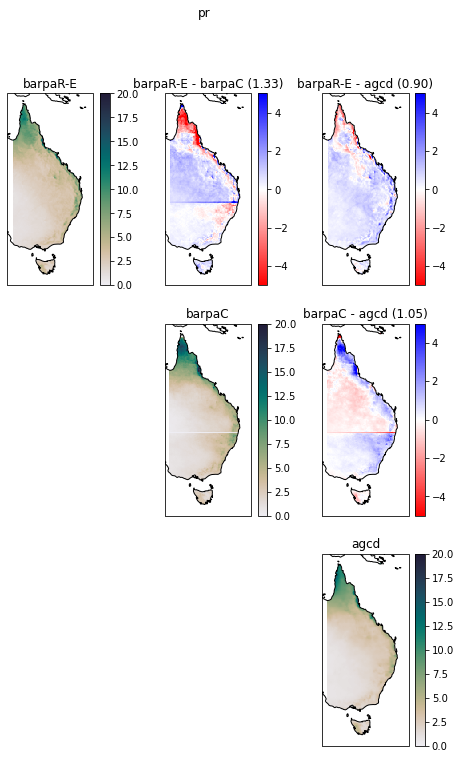

In [38]:
plt.figure(figsize=(8,12))
bias_plots2(data,'pr',1-lsm.data,['barpaR-E','barpaC','agcd'],0,20,5,cmocean.cm.rain,'bwr_r',"mm/day",Constraints=cx&cy)


In [21]:
for key in  ['barpaR-E','barpaC','agcd']:
   print(data[key]['pr'].extract(cx&cy).summary(shorten=True)) 

print(lsm.extract(cx&cy).summary(shorten=True))

      

MON MEAN PRECIPITATION IN MM DAY-1 / (mm day-1) (time: 25; latitude: 218; longitude: 98)
MON MEAN PRECIPITATION IN MM DAY-1 / (mm day-1) (time: 25; latitude: 218; longitude: 98)
lwe_thickness_of_precipitation_amount / (mm/day) (time: 25; latitude: 218; longitude: 98)
land_binary_mask / (1)              (latitude: 218; longitude: 98)
